In [1]:
%pylab inline
import numpy as np
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


# Data

In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from itertools import combinations

In [134]:
iris = load_iris()
data_x, data_y = iris.data, iris.target
data_x = data_x[data_y != 0]
data_y = data_y[data_y != 0]

train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.3, shuffle=True)

dataset = pd.DataFrame(np.column_stack([data_x, data_y]), columns=iris.feature_names + ['y'])
display(dataset.head())

print('data_x:', data_x.shape)
print('data_y:', data_y.shape)
print('train_x:', train_x.shape)
print('train_y:', train_y.shape)
print('test_x:', test_x.shape)
print('test_y:', test_y.shape)
print('unique target:', np.unique(data_y))

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),y
0,7.0,3.2,4.7,1.4,1.0
1,6.4,3.2,4.5,1.5,1.0
2,6.9,3.1,4.9,1.5,1.0
3,5.5,2.3,4.0,1.3,1.0
4,6.5,2.8,4.6,1.5,1.0


data_x: (100, 4)
data_y: (100,)
train_x: (70, 4)
train_y: (70,)
test_x: (30, 4)
test_y: (30,)
unique target: [1 2]


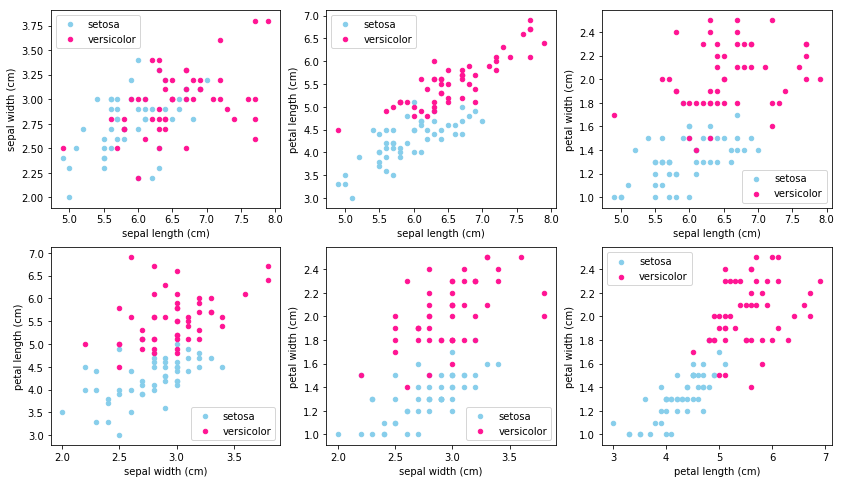

In [137]:
def visualize_dataset():
    features = iris.feature_names
    labels = iris.target_names
    colors = ['skyblue', 'deeppink', 'seagreen']
    
    # Make Combination of Features
    _a = np.arange(len(features))
    _comb = list(combinations(_a, 2))
    
    # Make Plot
    fig, plots = plt.subplots(2, 3)
    fig.set_figwidth(14)
    fig.set_figheight(8)
    plots = plots.reshape(-1)
    
    for i, (x, y) in enumerate(_comb):
        _plot = plots[i]
        dataset[dataset['y']==1].plot(x=x, y=y, ax=_plot, kind='scatter', label=labels[0], color=colors[0])
        dataset[dataset['y']==2].plot(x=x, y=y, ax=_plot, kind='scatter', label=labels[1], color=colors[1])
        
visualize_dataset()

# SVM with Scipy

In [138]:
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score

## Simple Example

In [139]:
clf = SVC(kernel='rbf')
clf.fit(train_x[:, :2], train_y)
pred_y = clf.predict(test_x[:, :2])

acc = accuracy_score(test_y, pred_y)
print(f'Accuracy: {acc:.4}')

Accuracy: 0.7


## Visualization

/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


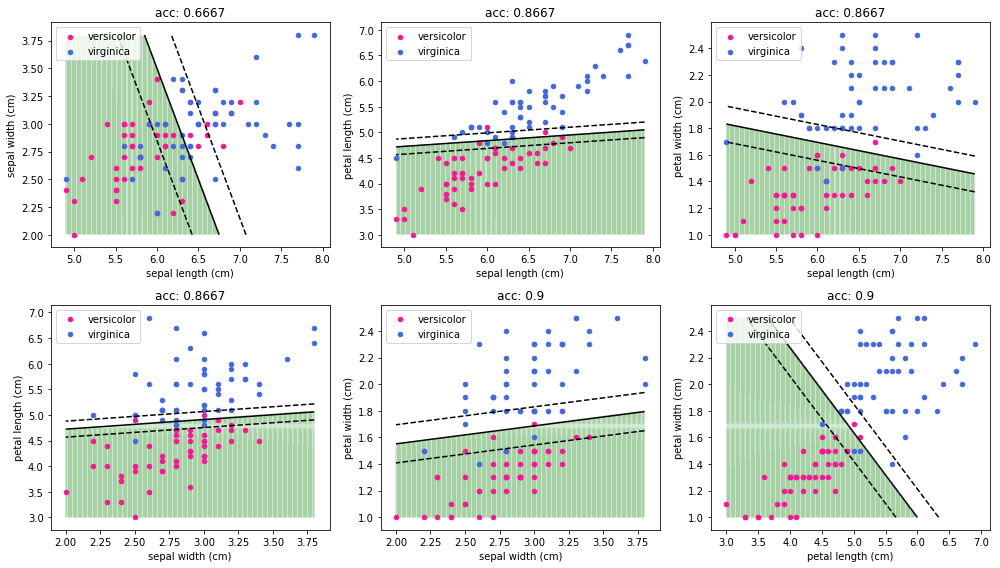

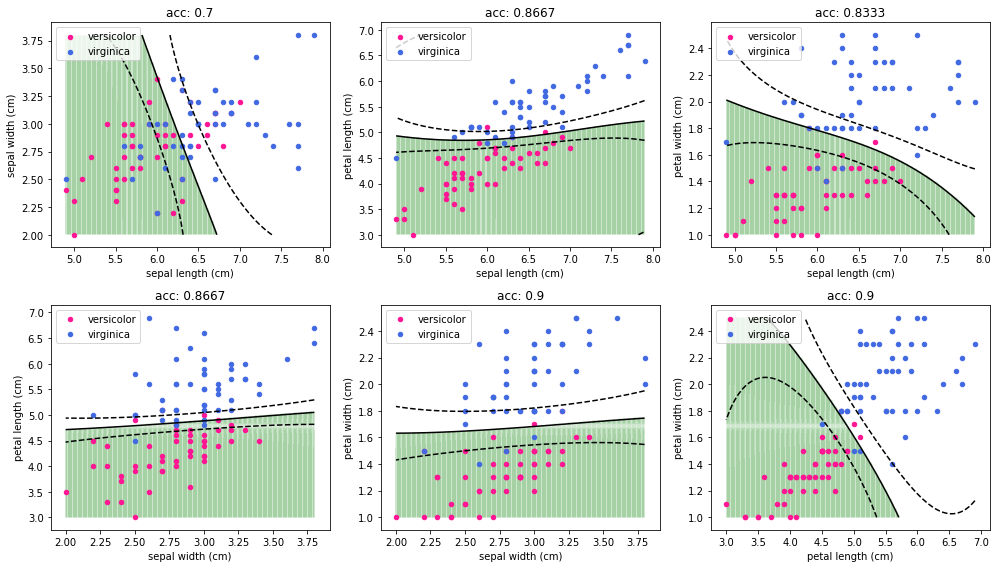

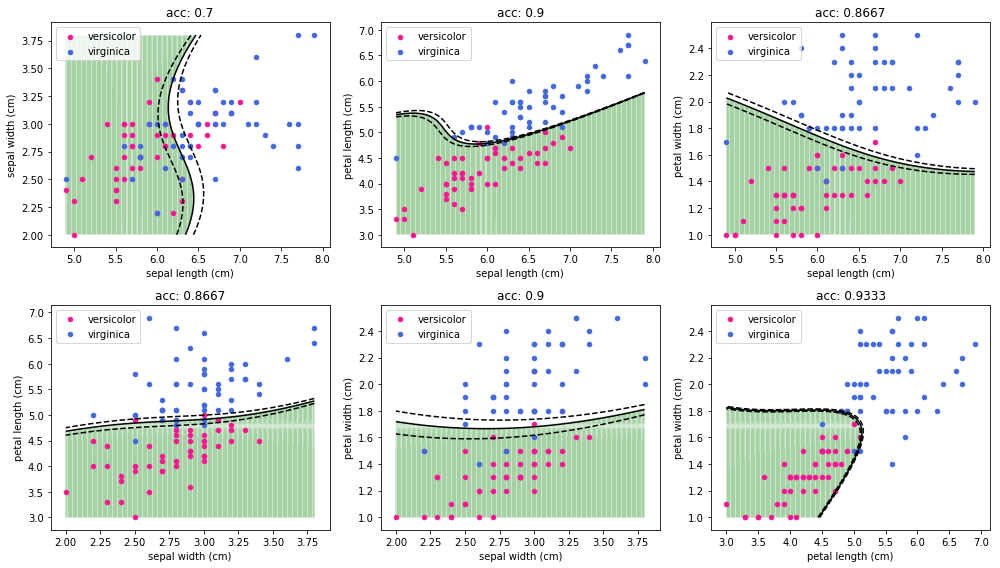

In [181]:
def visualize_dataset(model, kernel='rbf', **kwargs):
    features = iris.feature_names
    labels = iris.target_names
    colors = ['seagreen', 'deeppink', 'royalblue']
    
    # Make Combination of Features
    _a = np.arange(len(features))
    _comb = list(combinations(_a, 2))
    
    # Make Plot
    fig, plots = plt.subplots(2, 3)
    fig.set_figwidth(14)
    fig.set_figheight(8)
    fig.set_tight_layout(True)
    plots = plots.reshape(-1)
    
    for i, (x, y) in enumerate(_comb):
        _plot = plots[i]
        
        clf = SVC(kernel=kernel, **kwargs)
        clf.fit(train_x[:, [x, y]], train_y)
        pred_y = clf.predict(test_x[:, [x, y]])
        acc = accuracy_score(test_y, pred_y)
        
        f1_min = data_x[:, x].min()
        f1_max = data_x[:, x].max()
        f2_min = data_x[:, y].min()
        f2_max = data_x[:, y].max()
        xx, yy = np.mgrid[f1_min:f1_max:200j, f2_min:f2_max:200j]

        zz = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        zz = zz.reshape(xx.shape)
        
        _plot.set_title(f'acc: {acc:.4}')
        _plot.pcolormesh(xx, yy, zz > 0, cmap=plt.cm.ocean, alpha=0.1)
        _plot.contour(xx, yy, zz, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'], levels=[-.5, 0, .5])
        dataset[dataset['y']==1].plot(x=x, y=y, ax=_plot, kind='scatter', label=labels[1], color=colors[1])
        dataset[dataset['y']==2].plot(x=x, y=y, ax=_plot, kind='scatter', label=labels[2], color=colors[2])


visualize_dataset(clf, kernel='linear')
visualize_dataset(clf, kernel='rbf')
visualize_dataset(clf, kernel='poly', degree=5)

# SVM with Numpy

## Gradient Descent 

Linear Regression의 목표(objective)는 cost값을 낮추는 것입니다. 

$$ J(w_j) = \frac{1}{N} \sum^N_{i=1} (y_i - \hat{y}_i )^2  $$

위의 공식에서 예측값 $ \hat{y}_i $는 다음과 같습니다.<br>
$ w_0 $ 은 bias값입니다.

$$ \hat{y} = w^Tx = b + w_1x_1 + w_2x_2 + ... + w_nx_n = \sum_{j=0} w_j x_j$$

error값에 대한 Gradient Descent를 하기 위해서는 먼저 gradient를 구해야 합니다.<br>
gradient는 compass와 같으며, 아래로 내려가는 방향을 알려줍니다.

<span style="color:#aa3333">
$$ \frac{\partial}{\partial w} = \Delta w =  \frac{2}{N} \sum^N_{i=1} -x_i(y_i - \sum_{j=0}(w_j x_j )) $$
</span>

<span style="color:#aa3333">
$$ \frac{\partial}{\partial b} = \Delta b = \frac{2}{N} \sum^N_{i=1} -(y_i - \sum_{j=0}(w_j x_j)) $$
</span>

따라서 weights와 bias의 업데이트는 다음과 같이 합니다. 

$$ w = w - \eta \cdot \Delta w $$

$$ b = b - \eta \cdot \Delta b $$

In [4]:
def gradient_descent(x, y, w, eta=0.001):
    _w = np.zeros(2)
    N = float(len(data))
    for i in range(0, int(N)):
        update = (y[i] - w[1:].dot(x[i]) + w[0])
        _w[1:] += -(2/N) * update * x[i]
        _w[0] += -(2/N) * update
    new_weights = w - eta * _w
    return new_weights
    
def predict(x, w):
    x = np.array([x])
    return w[0] + w[1:].dot(x)

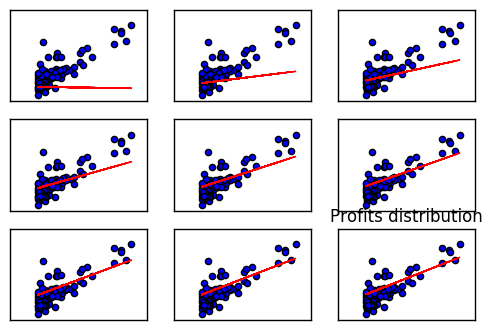

In [11]:
# 초기 weights 값
w = np.random.randn(2)
n_epoch = 9

# Predicting and Plotting
for i in range(1, n_epoch + 1):
    w = gradient_descent(data[:, 0], data[:, 1], w, eta=0.002)
    yhat = predict(data[:, 0], w)

    axes = subplot(3, 3, i)
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False)
    
    scatter(data[:, 0], data[:, 1])
    plot(data[:, 0], yhat, color='red')
    
title('Profits distribution')
xlabel('Population of City in 10,000s')
ylabel('Profit in $10,000s')
